# Element based HideNN-FEM

$\forall v\in V(\Omega), $ find $u\in H(\Omega)$,
$$\int_\Omega \nabla v \cdot \lambda(x) \nabla u = \int_\Omega f v  + \int_{\partial \Omega_N} g v$$

In [69]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)

## Space interpolation (legacy)

We recode 1D shape functions in HideNN-FEM (first order).


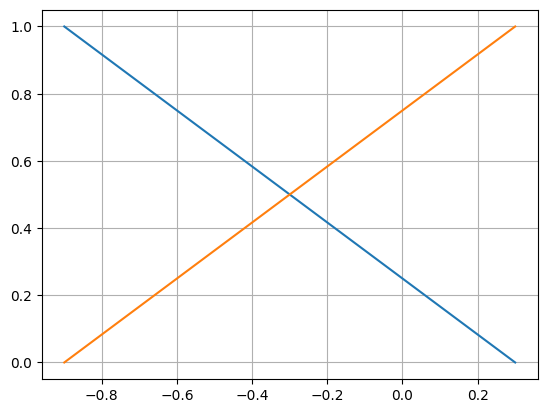

In [70]:
class mySF1D_elementBased(nn.Module):    # should inherit from nn.Module
    def __init__(self, left = -1.,  right = 1.):
        super().__init__()        # mandatory
        
        # our hyperparameters (arbitrary) :
        self.left = left
        self.right = right

        # pour transfert CUDA
        self.register_buffer('one', torch.tensor([1], dtype=torch.float32))

    def forward(self, x=None, training=False):  # define the function call
        if training : x = (self.left + self.right) / torch.tensor(2., requires_grad=True) # point de gauss pour le training
        #x.requires_grad = True # mystérieux
        sf1 = - (x - self.left) / (self.right - self.left) + self.one
        sf2 = (x - self.left)/(self.right - self.left)
        if training : return  sf1, sf2, self.right - self.left, x
        else : return  sf1, sf2


l, r =  -0.9, 0.3
mySF = mySF1D_elementBased(left = l, right = r)

XX = torch.linspace(l,r,100)
s1, s2 = mySF(XX)
plt.plot(XX.data, s1.data, XX.data, s2.data)
plt.grid()




## Vectorised version of the Element-based implementation

We recode 1D shape functions in HideNN-FEM (first order).

A vectorised implementation enables batch processing of several points evaluation which in terns enables batch wise differentiation.

* In non-batch implementation

    * `du_dx = [torch.autograd.grad(u[i], x[i], grad_outputs=torch.ones_like(u[i]), create_graph=True) for i,_ in enumerate(u)`

* With the batch version
    * `du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True) `


In [71]:
class mySF1D_elementBased_vectorised(nn.Module):
    def __init__(self, connectivity):
        super(mySF1D_elementBased_vectorised, self).__init__()
        if connectivity.dim == 1:
            connectivity = connectivity[:,None]
        self.connectivity = connectivity
        self.register_buffer('GaussPoint',self.GP())


    def UpdateConnectivity(self,connectivity):
        self.connectivity = connectivity.astype(int)

    def GP(self):
        "Defines the position of the intergration point(s) for the given element"

        return torch.tensor([[1/2, 1/2]], requires_grad=True)                  # a1, a2, th 2 area coordinates

    def forward(self, 
                x               : torch.Tensor  = None  , 
                cell_id         : list          = None  , 
                coordinates     : torch.Tensor  = None  , 
                flag_training   : bool          = False):

        assert coordinates is not None, "No nodes coordinates provided. Aborting"

        cell_nodes_IDs  = self.connectivity[cell_id,:].T
        Ids             = torch.as_tensor(cell_nodes_IDs).to(coordinates.device).t()[:,:,None]      # :,:,None] usefull only in 2+D  
        nodes_coord     = torch.gather(coordinates[:,None,:].repeat(1,2,1),0, Ids.repeat(1,1,1))    # [:,:,None] usefull only in 2+D  Ids.repeat(1,1,d) with d \in [1,3]
        
        nodes_coord = nodes_coord.to(self.GaussPoint.dtype)

        if flag_training:
            refCoordg   = self.GaussPoint.repeat(cell_id.shape[0],1)
            w_g         = 1                                                                         # Gauss weight
            Ng          = refCoordg
            x_g         = torch.einsum('enx,en->ex',nodes_coord,Ng)
            refCoord    = self.GetRefCoord(x_g,nodes_coord)
            N           = refCoord
            detJ        = nodes_coord[:,1] - nodes_coord[:,0]
            return N, x_g, detJ*w_g

        else:
            refCoord = self.GetRefCoord(x,nodes_coord)
            N = torch.stack((refCoord[:,0], refCoord[:,1]),dim=1) 
            return N

    
    def GetRefCoord(self,x, nodes_coord):
        InverseMapping          = torch.ones([int(nodes_coord.shape[0]), 2, 2], dtype=x.dtype, device=x.device)
        detJ                    = nodes_coord[:,0,0] - nodes_coord[:,1,0]
        InverseMapping[:,0,1]   = -nodes_coord[:,1,0]
        InverseMapping[:,1,1]   = nodes_coord[:,0,0]
        InverseMapping[:,1,0]   = -1*InverseMapping[:,1,0]
        InverseMapping[:,:,:]  /= detJ[:,None,None]
        x_extended = torch.stack((x, torch.ones_like(x)),dim=1)


        return torch.einsum('eij,ej...->ei',InverseMapping,x_extended.squeeze(1))

## Mesh generation

In [72]:
N           = 40
nodes       = torch.linspace(0,6.28,N)
nodes       = nodes[:,None]
elements    = torch.vstack([torch.arange(0,N-1),torch.arange(1,N)]).T

## Assembly using the vectorised element block

In [73]:
class interpolation1D(nn.Module):    
    def __init__(self, 
            nodes           : torch.Tensor  = None  , 
            elements        : list          = None  , 
            dirichlet       : list          =[0,nodes.shape[0]-1]     ,                 # Fixed nodes (by default, 2 extremities of the beam)
            n_components    : int           = 1     ):                                  # Number of dofs per node 
        super().__init__()        
        self.register_buffer('nodes', nodes)
        self.coordinates =nn.ParameterDict({
                                    'all': self.nodes,
                                    })                                                  # Should use different entries for trainable and fixed coordinates

        
        self.coordinates["all"].requires_grad   = False 
        self.n_components                       = n_components
        self.register_buffer('values',0.5*torch.ones((self.coordinates["all"].shape[0], self.n_components)))
        self.dirichlet = dirichlet

        
        # our hyperparameters (arbitrary) :
        self.elements = elements

        self.Ne = len(elements)

        self.shape_functions = mySF1D_elementBased_vectorised(elements)                 # convertit en liste de module pytorch

        # pour transfert CUDA
        self.register_buffer('one', torch.tensor([1], dtype=torch.float32))

        self.SetBCs()

    def SetBCs(self):
        assert self.n_components == 1, "only scalar field implemented. Aborting"
        if self.n_components == 1:
            self.dofs_free                  = (torch.ones_like(self.values[:])==1)[:,0]
            self.dofs_free[self.dirichlet]  = False
            


            nodal_values_imposed            = 0*self.values[~self.dofs_free,:]          # Not generic yet, only 0 BCs


            nodal_values_free               = self.values[self.dofs_free,:] #DEBUG
            # nodal_values_free               = torch.sin(self.coordinates["all"][1:-1])
            self.nodal_values               = nn.ParameterDict({
                                                'free'      : nodal_values_free,
                                                'imposed'   : nodal_values_imposed,
                                                })
            self.nodal_values['imposed'].requires_grad = False

    def forward(self, x = None): 
        # le self.training est là pour calculer les intégrales avec les points de Gauss
        if self.training :
            k_elt = torch.arange(0,self.Ne)
        else :
            # liste de k
            k_elt = []
            for xx in x:
                for k in range(self.Ne):
                    elt = self.elements[k]
                    if xx >= self.coordinates["all"][elt[0]] and xx <= self.coordinates["all"][elt[1]]:
                        k_elt.append(k)
                        break
        if self.training : 
            shape_functions, x_g, detJ = self.shape_functions(
                x               = x                 , 
                cell_id         = k_elt             , 
                coordinates     = self.nodes        , 
                flag_training   = self.training     )
        else:
            shape_functions = self.shape_functions(
                x               = x                 , 
                cell_id         = k_elt             , 
                coordinates     = self.nodes        , 
                flag_training   = self.training     )
        # Batch interpolation of the solution using the computed shape functions batch
        # nodal_values_tensor                     = torch.ones_like(self.values)
        nodal_values_tensor                     = torch.randn_like(self.values)
        nodal_values_tensor[self.dofs_free,:]   = self.nodal_values['free']
        # print(self.nodal_values['free'])
        nodal_values_tensor[~self.dofs_free,:]  = self.nodal_values['imposed']                    

        cell_nodes_IDs      = self.elements[k_elt,:].T
        Ids                 = torch.as_tensor(cell_nodes_IDs).to(nodal_values_tensor.device).t()[:,:,None]      # :,:,None] usefull only in 2+D  

        
        self.nodes_values   = torch.gather(nodal_values_tensor[:,None,:].repeat(1,2,1),0, Ids.repeat(1,1,1))    # [:,:,None] usefull only in 2+D  Ids.repeat(1,1,d) with d \in [1,3]
        self.nodes_values   = self.nodes_values.to(shape_functions.dtype)
        u = torch.einsum('gi...,gi->g',self.nodes_values,shape_functions)   

        if self.training : 

            return u, x_g, detJ
        else:
            return u


In [74]:
model = interpolation1D(nodes, elements)
model.train()
print("* Model set in training mode")

* Model set in training mode


## Training with batch version

### Supervised learning

Let's first try to learn a cosine function using supervised learning

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
MSE = nn.MSELoss()
# Training
Nepoch          = 100
lossList        = []
lossTraining    = []
model.train()
for i in range(Nepoch):
    u, x_g, detJ    = model()
    loss            = MSE(u,torch.sin(x_g)[:,0])
    optimizer.zero_grad()    # necessaire pour réinitialiser les gradients
    loss.backward()          # compute the gradients (chain rule)
    optimizer.step()
    lossTraining.append(loss.data)
    print(f"{i = } | loss = {loss.data :.2e}", end = "\r")

#### Post-processing

Text(0, 0.5, 'Loss')

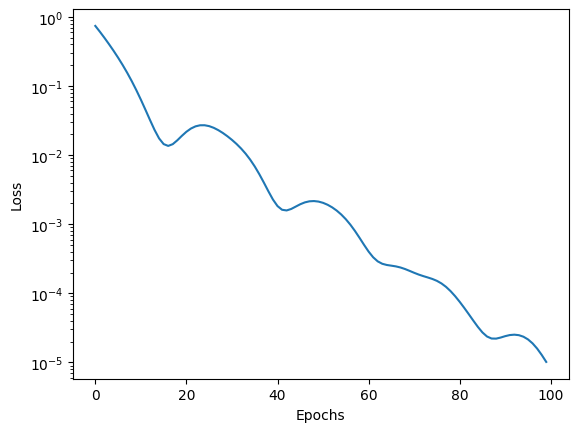

In [76]:
import matplotlib.pyplot as plt

plt.figure()
plt.semilogy(lossTraining)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'u(x) [mm]')

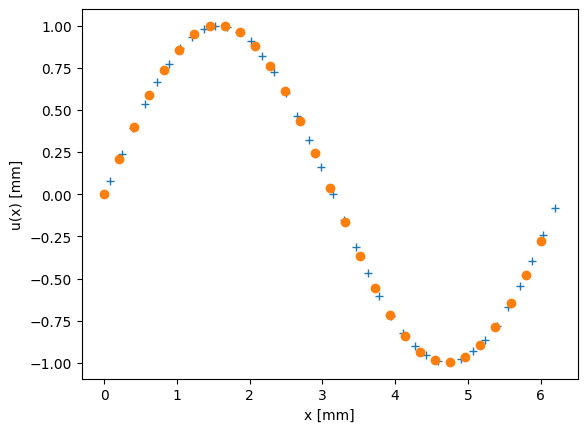

In [77]:

model.eval()

x_test = torch.linspace(0,6,30)
u_eval = model(x_test)
plt.figure()
plt.plot(x_g.data,u.data, '+')
plt.plot(x_test.data,u_eval.data, 'o')
plt.xlabel("x [mm]")
plt.ylabel("u(x) [mm]")

Text(0, 0.5, 'du/dx [mm/mm]')

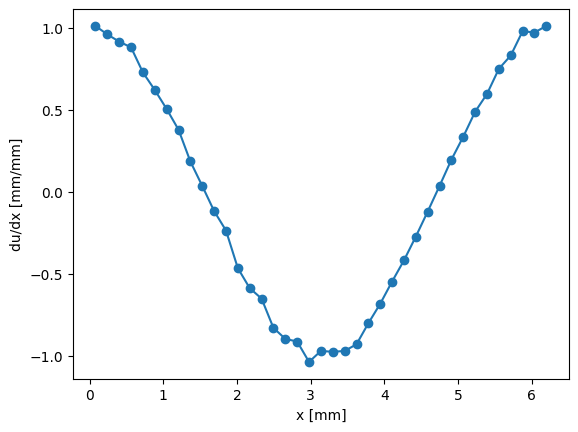

In [78]:
model.train()
u, x_g, detJ    = model()
du_dxg = torch.autograd.grad(u, x_g, grad_outputs=torch.ones_like(u), create_graph=True)[0]
plt.figure()
plt.plot(x_g.data,du_dxg.data, '-o')
plt.xlabel("x [mm]")
plt.ylabel("du/dx [mm/mm]")

### Unsupervised learning

Let's now try to solve a partial derivative equation (PDE) defined at the begining of this notebook.

In [79]:
def PotentialEnergy(u,x,f,J):
    """Computes the potential energy of the Beam, which will be used as the loss of the HiDeNN"""
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # on somme aux points (on espère de Gauss)
# Vectorised calculation of the integral terms
    int_term1 =  0.5 * du_dx*du_dx * J
    int_term2 =  f(x) * J * u

    # Vectorised calculation of the integral using the trapezoidal rule
    integral = torch.sum(int_term1 - int_term2)
    return integral

def f(x):
    return 1000 #-x*(x-10)

In [80]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1)
# Training
Nepoch          = 7000
lossList        = []
lossTraining    = []
model.train()
for i in range(Nepoch):
    u, x_g, detJ    = model()
    loss            = PotentialEnergy(u,x_g,f,detJ)
    optimizer.zero_grad()    # necessaire pour réinitialiser les gradients
    loss.backward()          # compute the gradients (chain rule)
    optimizer.step()
    lossTraining.append(loss.data)
    print(f"{i = } | loss = {loss.data :.2e}", end = "\r")

#### Post-processing

Here the loss can be negative so a log plot is not (directly) possible

Text(0, 0.5, 'Loss')

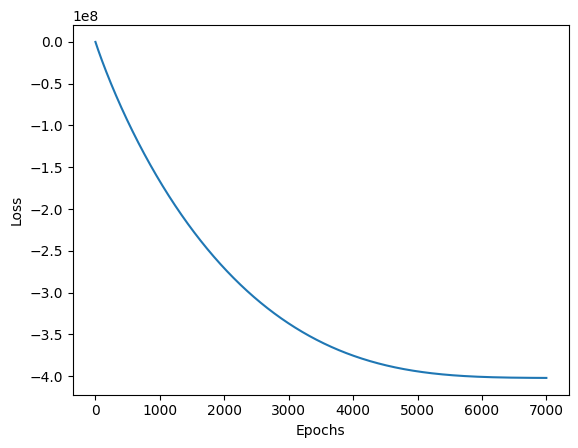

In [81]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(lossTraining)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'u(x) [mm]')

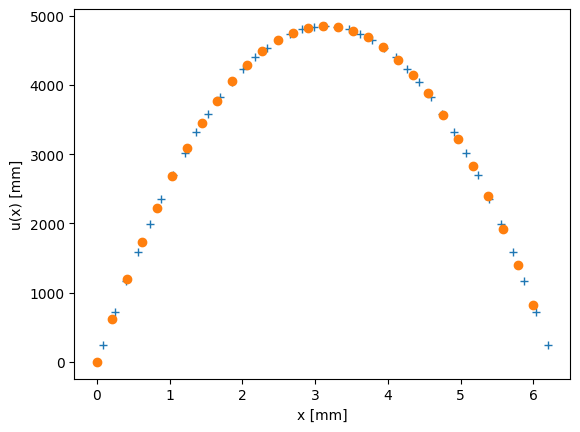

In [82]:

model.eval()

x_test = torch.linspace(0,6,30)
u_eval = model(x_test)
plt.figure()
plt.plot(x_g.data,u.data, '+')
plt.plot(x_test.data,u_eval.data, 'o')
plt.xlabel("x [mm]")
plt.ylabel("u(x) [mm]")

Text(0, 0.5, 'du/dx [mm/mm]')

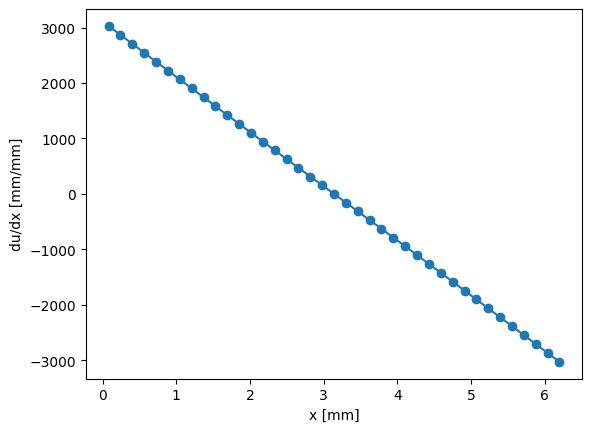

In [83]:
model.train()
u, x_g, detJ    = model()
du_dxg = torch.autograd.grad(u, x_g, grad_outputs=torch.ones_like(u), create_graph=True)[0]
plt.figure()
plt.plot(x_g.data,du_dxg.data, '-o')
plt.xlabel("x [mm]")
plt.ylabel("du/dx [mm/mm]")